In [572]:
import subprocess
import os
import xml.etree.ElementTree as ET
from copy import deepcopy
from dataclasses import dataclass
from tempfile import TemporaryDirectory
from time import sleep

from rdkit import Chem
from rdkit.Chem.AllChem import EmbedMolecule
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem.rdMolTransforms import SetBondLength, SetAngleDeg, SetDihedralDeg, GetBondLength, GetAngleDeg, GetDihedralDeg

from sklearn.metrics import r2_score, mean_squared_error
import jax.numpy as jnp
from jax.scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import parmed
import openmm
from openmm import LangevinMiddleIntegrator, app, unit

IPythonConsole.drawOptions.addAtomIndices = True


def shake_mol(mol, n_mols=20):
    n_atoms = mol.GetNumAtoms()
    shook_mols = []
    for i in range(n_mols):
        tmp_mol = Chem.Mol(mol)
        conf = tmp_mol.GetConformer()
        atom_index_to_shake = i % n_atoms
        shakes = np.random.normal(scale=0.05, size=3)
        pos = np.array(conf.GetAtomPosition(atom_index_to_shake))
        pos += shakes
        pos = Point3D(*pos)
        conf.SetAtomPosition(atom_index_to_shake, pos)

        shook_mols.append(tmp_mol)

    return shook_mols

def mol_to_xtb_opt(mol):
    with TemporaryDirectory() as tmp_dir:
        Chem.MolToXYZFile(mol, os.path.join(tmp_dir, 'input.xyz'))
        subprocess.run([
            'xtb',
            'input.xyz',
            '--opt',
            '--chrg',
            str(Chem.GetFormalCharge(mol)),
            '--gfn',
            '2',
            '--alpb',
            'water'
        ], cwd=tmp_dir, stdout=-1, stderr=-1)
        sleep(0.1)
        xyz_block = open(os.path.join(tmp_dir, 'xtbopt.xyz')).read()

    ret_mol = Chem.Mol(mol)
    conf = ret_mol.GetConformer()
    for i, line in enumerate(xyz_block.splitlines()[2:]):
        x_y_z = [float(val) for val in line.split()[1:]]
        conf.SetAtomPosition(i, Point3D(*x_y_z))

    return ret_mol

def mol_to_xtb_energy(mol):
    with TemporaryDirectory() as tmp_dir:
        Chem.MolToXYZFile(mol, os.path.join(tmp_dir, 'input.xyz'))
        proc = subprocess.run([
            'xtb',
            'input.xyz',
            '--chrg',
            str(Chem.GetFormalCharge(mol)),
            '--gfn',
            '2',
            '--alpb',
            'water'
        ], cwd=tmp_dir, stdout=-1, stderr=-1)
        for line in proc.stdout.splitlines():
            if b'TOTAL ENERGY' in line:
                return float(line.split()[3]) * 627.5  # kcal/mol

def mol_to_xtb_charges(mol):
    with TemporaryDirectory() as tmp_dir:
        Chem.MolToXYZFile(mol, os.path.join(tmp_dir, 'input.xyz'))
        subprocess.run([
            'xtb',
            'input.xyz',
            '--chrg',
            str(Chem.GetFormalCharge(mol)),
            '--gfn',
            '2',
            '--alpb',
            'water'
        ], cwd=tmp_dir, stdout=-1, stderr=-1)
        charges = open(os.path.join(tmp_dir, 'charges')).read()

    return np.array([float(val) for val in charges.split()])

def mol_to_am1_bcc_charges(mol):
    with TemporaryDirectory() as tmp_dir:
        Chem.MolToMolFile(mol, os.path.join(tmp_dir, 'input.sdf'))
        proc = subprocess.run([
            'antechamber',
            '-i',
            'input.sdf',
            '-fi',
            'mdl',
            '-c',
            'bcc',
            'cf',
            'output.charges',
        ], cwd=tmp_dir)
        charges = open(os.path.join(tmp_dir, 'output.charges')).read()

    return charges

def mol_to_structure(mol, bond_parameters):
    bond_parameters = bond_parameters.reshape((-1, 2))

    with TemporaryDirectory() as tmp_dir:
        Chem.MolToPDBFile(mol, f'{tmp_dir}/mol.pdb')
        structure = parmed.load_file(f'{tmp_dir}/mol.pdb')

    for bond, bond_parameter in zip(structure.bonds, bond_parameters):
        bond.type = parmed.BondType(bond_parameter[0], bond_parameter[1])

    return structure

def structure_to_openmm_energy(structure):
    system = structure.createSystem()
    simulation = app.Simulation(structure.topology, system, LangevinMiddleIntegrator(300*unit.kelvin, 1/unit.picosecond, 0.004*unit.picoseconds))
    simulation.context.setPositions(structure.positions)
    return simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilocalorie / unit.mole)  # kcal/mol

def mol_to_bond_indices(mol):
    return np.array(sorted(mol.GetSubstructMatches(Chem.MolFromSmarts('*~*'))))

def mol_to_angle_indices(mol):
    return np.array(sorted(mol.GetSubstructMatches(Chem.MolFromSmarts('*~*~*'))))

def mol_to_dihedral_indices(mol: Chem.Mol):
    all_dihedrals = mol.GetSubstructMatches(Chem.MolFromSmarts('*~*!@*~*'))
    unique_dihedrals = []
    for dihedral in all_dihedrals:
        if not any([dihedral[1:3] == u_d[1:3] or dihedral[1:3] == tuple(reversed(u_d[1:3])) for u_d in unique_dihedrals]):
            unique_dihedrals.append(dihedral)

    return np.array(sorted(unique_dihedrals))

def mol_to_outofplane_indices(mol):
    return np.array(sorted(mol.GetSubstructMatches(Chem.MolFromSmarts('*~[*X3;$(a),$(*=*)](~*)(~*)'))))

def parse_proper_torsion(proper_torsion):
    params = []

    periodicities = [
        proper_torsion.get(f'periodicity{i}')
        for i in range(1, 7)
    ]
    periodicities = [int(val) for val in periodicities if val is not None]
    phases = [
        proper_torsion.get(f'phase{i}')
        for i in range(1, 7)
    ]
    phases = [float(val.split()[0]) for val in phases if val is not None]
    ks = [
        proper_torsion.get(f'k{i}')
        for i in range(1, 7)
    ]
    ks = [float(val.split()[0]) for val in ks if val is not None]

    for i in range(1, 7):
        if i in periodicities:
            index = periodicities.index(i)
            params += [ks[index], phases[index]]
        else:
            params += [0, 0]

    return params

In [581]:
@dataclass
class JaxMol:
    mol: Chem.Mol
    charges: jnp.array
    bond_indices: jnp.array
    angle_indices: jnp.array
    proper_dihedral_indices: jnp.array
    improper_dihedral_indices: jnp.array
    bond_angstroms: jnp.array
    angle_degrees: jnp.array
    proper_dihedral_degrees: jnp.array
    improper_dihedral_degrees: jnp.array
    distance_matrix: jnp.array

    def __post_init__(self):
        pass

    def load_params(self, offxml):
        xml_smirnoff = ET.ElementTree(file=offxml).getroot()
        num_atoms = self.mol.GetNumAtoms()
        
        vdw_params = [-1] * num_atoms
        xml_vdw = xml_smirnoff.find('vdW')
        for atom_idx in range(num_atoms):
            for element in xml_vdw:
                if atom_idx in [
                    match[0]
                    for match in self.mol.GetSubstructMatches(Chem.MolFromSmarts(element.get('smirks')))
                ]:
                    vdw_params[atom_idx] = [
                        float(element.get('epsilon').split()[0]),
                        float(element.get('rmin_half').split()[0]),
                    ]
        self.vdw_params = jnp.array(vdw_params)

        bond_params = [-1] * len(self.bond_indices)
        xml_bonds = xml_smirnoff.find('Bonds')
        for i, bond_index in enumerate(self.bond_indices):
            for element in xml_bonds:
                if tuple(int(val) for val in bond_index) in [
                    match[:2]
                    for match in self.mol.GetSubstructMatches(Chem.MolFromSmarts(element.get('smirks')))
                ]:
                    bond_params[i] = [
                        float(element.get('k').split()[0]),
                        float(element.get('length').split()[0])
                    ]
        self.bond_params = jnp.array(bond_params)

        angle_params = [-1] * len(self.angle_indices)
        xml_angles = xml_smirnoff.find('Angles')
        for i, angle_index in enumerate(self.angle_indices):
            for element in xml_angles:
                angle_index = tuple(int(val) for val in angle_index)
                matches = [
                    match[:3]
                    for match in self.mol.GetSubstructMatches(Chem.MolFromSmarts(element.get('smirks')))
                ]
                if angle_index in matches or tuple(reversed(angle_index)) in matches:
                    angle_params[i] = [
                        float(element.get('k').split()[0]),
                        float(element.get('angle').split()[0])
                    ]
        self.angle_params = jnp.array(angle_params)

        proper_dihedral_params = [-1] * len(self.proper_dihedral_indices)
        xml_proper_dihedrals = xml_smirnoff.find('ProperTorsions')
        for i, proper_dihedral_index in enumerate(self.proper_dihedral_indices):
            for element in xml_proper_dihedrals:
                proper_dihedral_index = tuple(int(val) for val in proper_dihedral_index)
                matches = [
                    match[:4]
                    for match in self.mol.GetSubstructMatches(Chem.MolFromSmarts(element.get('smirks')))
                ]
                if proper_dihedral_index in matches or tuple(reversed(proper_dihedral_index)) in matches:
                    proper_dihedral_params[i] = parse_proper_torsion(element)
        self.proper_dihedral_params = jnp.array(proper_dihedral_params)


        cursor = 0

        vdw_params_flat = self.vdw_params.flatten()
        self.vdw_params_slice = (0, len(vdw_params_flat))
        cursor += len(vdw_params_flat)

        bond_params_flat = self.bond_params.flatten()
        self.bond_params_slice = (cursor, cursor + len(bond_params_flat))
        cursor += len(bond_params_flat)

        angle_params_flat = self.angle_params.flatten()
        self.angle_params_slice = (cursor, cursor + len(angle_params_flat))
        cursor += len(angle_params_flat)

        proper_dihedral_params_flat = self.proper_dihedral_params.flatten()
        self.proper_dihedral_params_slice = (cursor, cursor + len(proper_dihedral_params_flat))
        cursor += len(proper_dihedral_params_flat)

        self.params = jnp.concatenate([
            vdw_params_flat,
            bond_params_flat,
            angle_params_flat,
            proper_dihedral_params_flat,
        ])

        return self

    def set_params(self, params):
        if len(self.params) != len(params):
            raise ValueError(f'expected len(params)={len(self.params)}, got len(params)={len(params)}')

        self.params = params
        self.vdw_params = params[self.vdw_params_slice[0] : self.vdw_params_slice[1]].reshape((-1, 2))
        self.bond_params = params[self.bond_params_slice[0] : self.bond_params_slice[1]].reshape((-1, 2))
        self.angle_params = params[self.angle_params_slice[0] : self.angle_params_slice[1]].reshape((-1, 2))
        self.proper_dihedral_params = params[self.proper_dihedral_params_slice[0] : self.proper_dihedral_params_slice[1]].reshape((-1, 12))

        return self

    def _energy(self):
        energy = jnp.array(0)

        for bond_angstrom, bond_param in zip(self.bond_angstroms, self.bond_params):
            energy += (bond_param[0] / 2) * jnp.power(bond_param[1] - bond_angstrom, 2)

        for angle_degree, angle_param in zip(self.angle_degrees, self.angle_params):
            energy += (angle_param[0] / (2 * 3282.80869764)) * jnp.power(angle_param[1] - angle_degree, 2)

        for proper_dihedral_degree, proper_dihedral_param in zip(self.proper_dihedral_degrees, self.proper_dihedral_params):
            for i in range(6):
                energy += proper_dihedral_param[i * 2] * (1 + jnp.cos((i + 1) * proper_dihedral_degree - proper_dihedral_param[i * 2 + 1]))

        return energy

    def energy(self):
        return float(self._energy())

    def optimize_params(self, ref_mols, ref_energies):
        jaxmols = [
            self.copy().set_positions_from_rdkit(mol)
            for mol in ref_mols
        ]

        def opt_func(jaxmols, ref_energies, params):
            jax_energies = jnp.array([
                jaxmol.set_params(params)._energy()
                for jaxmol in jaxmols
            ])

            return jnp.sqrt(jnp.average(jnp.power(ref_energies - jax_energies, 2)))

        res = minimize(
            lambda x: opt_func(jaxmols, ref_energies, x),
            x0 = self.params,
            method='BFGS'
        )

        self.set_params(res.x)

    def optimize_positions(self):
        pass

    def set_positions_from_rdkit(self, mol):
        conf = mol.GetConformer()
        self.bond_angstroms = jnp.array([
            GetBondLength(conf, *[int(val) for val in bond_index])
            for bond_index in self.bond_indices
        ])

        self.angle_degrees = jnp.array([
            GetAngleDeg(conf, *[int(val) for val in angle_index])
            for angle_index in self.angle_indices
        ])

        self.proper_dihedral_degrees = jnp.array([
            GetDihedralDeg(conf, *[int(val) for val in dihedral_index])
            for dihedral_index in self.proper_dihedral_indices
        ])

        self.improper_dihedral_degrees = jnp.array([
            GetDihedralDeg(conf, *[int(val) for val in dihedral_index])
            for dihedral_index in self.improper_dihedral_indices
        ])

        return self

    @classmethod
    def from_smi(cls, smi):
        mol = Chem.AddHs(Chem.MolFromSmiles(smi))
        EmbedMolecule(mol)
        mol = mol_to_xtb_opt(mol)

        return JaxMol.from_rdkit(mol)

    @classmethod
    def from_rdkit(cls, mol):
        if type(mol) != Chem.Mol:
            raise ValueError('mol must be an rdkit Mol')
        if Chem.MolToSmiles(mol) != Chem.MolToSmiles(Chem.AddHs(mol)):
            raise ValueError('mol is missing explicit hydrogens')
        try: conf = mol.GetConformer()
        except ValueError: raise ValueError('mol is missing conformer')

        bond_indices = jnp.array(mol_to_bond_indices(mol))
        angle_indices = jnp.array(mol_to_angle_indices(mol))
        dihedral_indices = jnp.array(mol_to_dihedral_indices(mol))
        outofplane_indices = jnp.array(mol_to_outofplane_indices(mol))

        bond_angstroms = jnp.array([
            GetBondLength(conf, *[int(val) for val in bond_index])
            for bond_index in bond_indices
        ])

        angle_degrees = jnp.array([
            GetAngleDeg(conf, *[int(val) for val in angle_index])
            for angle_index in angle_indices
        ])

        proper_dihedral_degrees = jnp.array([
            GetDihedralDeg(conf, *[int(val) for val in dihedral_index])
            for dihedral_index in dihedral_indices
        ])

        improper_dihedral_degrees = jnp.array([
            GetDihedralDeg(conf, *[int(val) for val in dihedral_index])
            for dihedral_index in outofplane_indices
        ])

        return JaxMol(
            mol,
            jnp.array(mol_to_xtb_charges(mol)),
            bond_indices,
            angle_indices,
            dihedral_indices,
            outofplane_indices,
            bond_angstroms,
            angle_degrees,
            proper_dihedral_degrees,
            improper_dihedral_degrees,
            jnp.array(Chem.GetDistanceMatrix(mol)),
        )

    def copy(self):
        return deepcopy(self)

In [582]:
jaxmol = JaxMol.from_smi('CC')
jaxmol.load_params('base.offxml')
jaxmol.energy()

8.526041030883789

In [590]:
jaxmol = JaxMol.from_smi('OO')
jaxmol.load_params('base.offxml')

mol = Chem.Mol(jaxmol.mol)
ref_mols = [mol] + shake_mol(mol, mol.GetNumAtoms() * 3)
ref_energies = np.array([mol_to_xtb_energy(mol) for mol in ref_mols])
ref_energies = np.array([val - min(ref_energies) for val in ref_energies])

print('old bond_params:', jaxmol.bond_params)
print('old angle_params:', jaxmol.angle_params)
print('old proper_dihedral_params', jaxmol.proper_dihedral_params)
jaxmol.optimize_params(ref_mols, ref_energies)
print('new bond_params:', jaxmol.bond_params)
print('new angle_params:', jaxmol.angle_params)
print('new proper_dihedral_params', jaxmol.proper_dihedral_params)

old bond_params: [[6.0006274e+02 1.4512039e+00]
 [1.0870536e+03 9.7167635e-01]
 [1.0870536e+03 9.7167635e-01]]
old angle_params: [[130.18123 110.35388]
 [130.18123 110.35388]]
old proper_dihedral_params [[0.        0.        0.4009661 0.        0.        0.        0.
  0.        0.        0.        0.        0.       ]]
new bond_params: [[6.0008911e+02 1.4371415e+00]
 [1.0870309e+03 9.9156642e-01]
 [1.0870869e+03 9.7719109e-01]]
new angle_params: [[129.77473 101.66384]
 [130.13667 107.9117 ]]
new proper_dihedral_params [[-0.9022965  -0.5381786   0.07273601  1.3738536  -0.79359794 -1.226052
  -0.16324176 -1.0576682   0.5749036   1.2743803   0.09866795  0.5385451 ]]


rmse: 0.0127841158106486
R^2: 0.9999612284743661


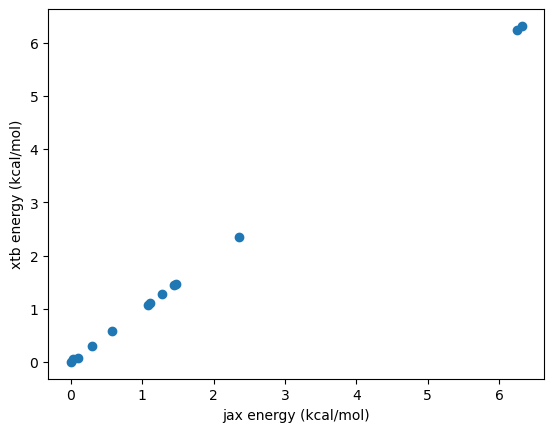

In [591]:
jax_energies = np.array([jaxmol.copy().set_positions_from_rdkit(mol).energy() for mol in ref_mols])

print('rmse:', np.sqrt(mean_squared_error(jax_energies, ref_energies)))
print('R^2:', r2_score(jax_energies, ref_energies))

plt.scatter(jax_energies, ref_energies)
plt.xlabel('jax energy (kcal/mol)')
plt.ylabel('xtb energy (kcal/mol)')
plt.show()